In [1]:
import mne
import autoreject #version 0.3.1 https://autoreject.github.io/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

subj_num = '0025'
subj_num_alt = ''.join([x for x in subj_num if x != '0'])#subj num coded diffferently for epohcs

## Importing raw data to create mne's info structure

In [2]:
raw = mne.io.read_raw_brainvision("/media/gweindel/2563485E45D6BE9E1/EEG_data/Boehm_CNV/eeg4/MD3-%s.vhdr"%subj_num, preload =False)
raw.set_channel_types({'EOGh':'eog','EOGv':'eog', 'A1':'misc', 'A2':'misc'})#declare type to avoid confusion with EEG channels
raw.rename_channels({'FP1':'Fp1', 'FP2':'Fp2'})#Naming convention
raw.set_montage('standard_1020')#Standard 1020 electrode montage
raw.rename_channels({'Fp1':'FP1', 'Fp2':'FP2'})
#raw.plot_sensors(ch_type='eeg')

Extracting parameters from /media/gweindel/2563485E45D6BE9E1/EEG_data/Boehm_CNV/eeg4/MD3-0025.vhdr...
Setting channel info structure...


/tmp/ipykernel_149291/1277617053.py:4: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['A1', 'A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020')#Standard 1020 electrode montage


<RawBrainVision | MD3-0025.eeg, 34 x 1424720 (2849.4 s), ~52 kB, data not loaded>

## Loading epochs

Not setting metadata
200 matching events found
No baseline correction applied
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


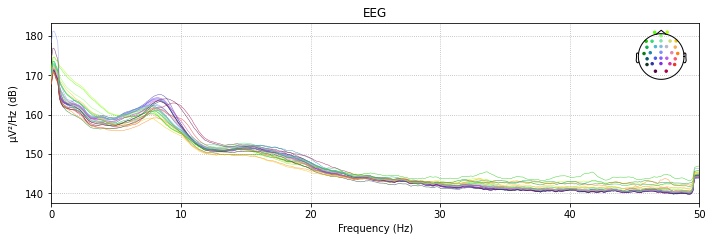

In [3]:
epochs = mne.io.read_epochs_fieldtrip("/media/gweindel/2563485E45D6BE9E1/EEG_data/Boehm_CNV/data%s.mat"%subj_num_alt, info=raw.info)
%matplotlib inline
epochs.plot_psd(fmax=50);

## Filtering, cropping, apply baseling resample and re-reference the epochs

In [4]:
epochs.filter(1,35)#same badwidth filter as van Maanen, Portoles & Borst (2021)
epochs.crop(tmin=-.250)
epochs.resample(100)
epochs.set_eeg_reference('average')
%matplotlib qt
epochs.plot(block=True, n_channels=32, scalings=100);#Marking bad electrodes

Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1651 samples (3.302 sec)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Using matplotlib as 2D backend.
Opening epochs-browser...
Closing epochs-browser...
Dropped 1 epoch: 6
The following epochs were marked as bad and are dropped:
[6]
Channels marked as bad:
none


## Applying ICA

In [5]:
ica = mne.preprocessing.ICA(n_components = 30-len(epochs.info["bads"])-1)# -1 for rank deficiency due to average ref
ica.fit(epochs, reject_by_annotation=True)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 29 components
Fitting ICA took 4.4s.


Method,fastica
Fit,31 iterations on epochs (64675 samples)
ICA components,29
Explained variance,100.0 %
Available PCA components,30
Channel types,eeg
ICA components marked for exclusion,—


In [7]:
%matplotlib qt

ica.plot_components(inst=epochs)

[<MNEFigure size 702x696 with 20 Axes>, <MNEFigure size 702x357 with 9 Axes>]

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS wi

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


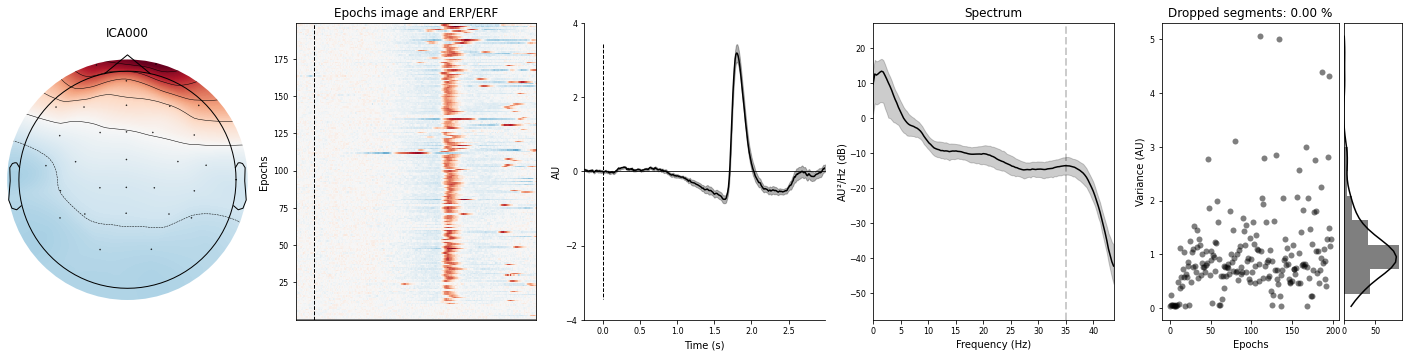

In [8]:
%matplotlib inline 
n_comp = len(ica.exclude)
fig, ax = plt.subplots(n_comp, 5, figsize = (25, len(ica.exclude)*5))
i = 0
for comp in ica.exclude:
    if n_comp >1:
        ica.plot_properties(epochs, picks=comp, axes=ax[i,:], show=False);
    else:
        ica.plot_properties(epochs, picks=comp, axes=ax[:], show=False);
    i += 1
plt.show()

## Applying ICA

[0]
Applying ICA to Evoked instance
    Transforming to ICA space (29 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


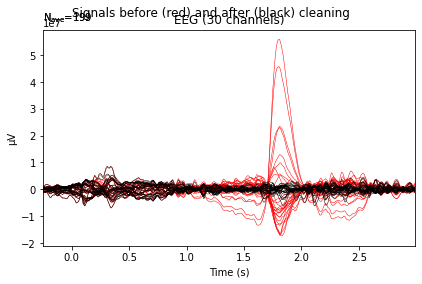

In [9]:
%matplotlib inline 
print(ica.exclude)
ica.plot_overlay(epochs.average(), exclude=ica.exclude, picks='eeg');

In [10]:
ica.apply(epochs)


Applying ICA to Epochs instance
    Transforming to ICA space (29 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


Number of events,199
Events,1: 199
Time range,-0.250 – 2.990 sec
Baseline,off


### Interpolate (eventual) bad electrodes

Applying baseline correction (mode: mean)
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_149291/2972015899.py:1: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs.interpolate_bads()


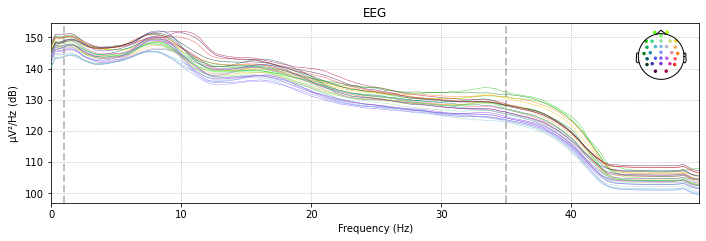

In [11]:
epochs.interpolate_bads()
epochs.pick_types(eeg=True)
epochs.apply_baseline(baseline=(None, 0))
%matplotlib inline
epochs.plot_psd(fmax=50);

## Rejecting bad epochs

In [12]:
%matplotlib inline

ar = autoreject.AutoReject(consensus=np.linspace(0, .4, 10), n_interpolate = np.arange(1,round(len(epochs.ch_names)/5)), n_jobs=-1) #I constrain the consensus parameter to be <=.4 as trials with almost half bad chan should be rejected
ar.fit(epochs)  # fit on the first 20 epochs to save time
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/30 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/199 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/199 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/199 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/199 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/199 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/199 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.31 and n_interpolate=2


  0%|          | Repairing epochs : 0/199 [00:00<?,       ?it/s]

Dropped 21 epochs: 20, 56, 75, 76, 84, 110, 114, 120, 126, 129, 130, 150, 151, 167, 171, 172, 176, 177, 193, 194, 197


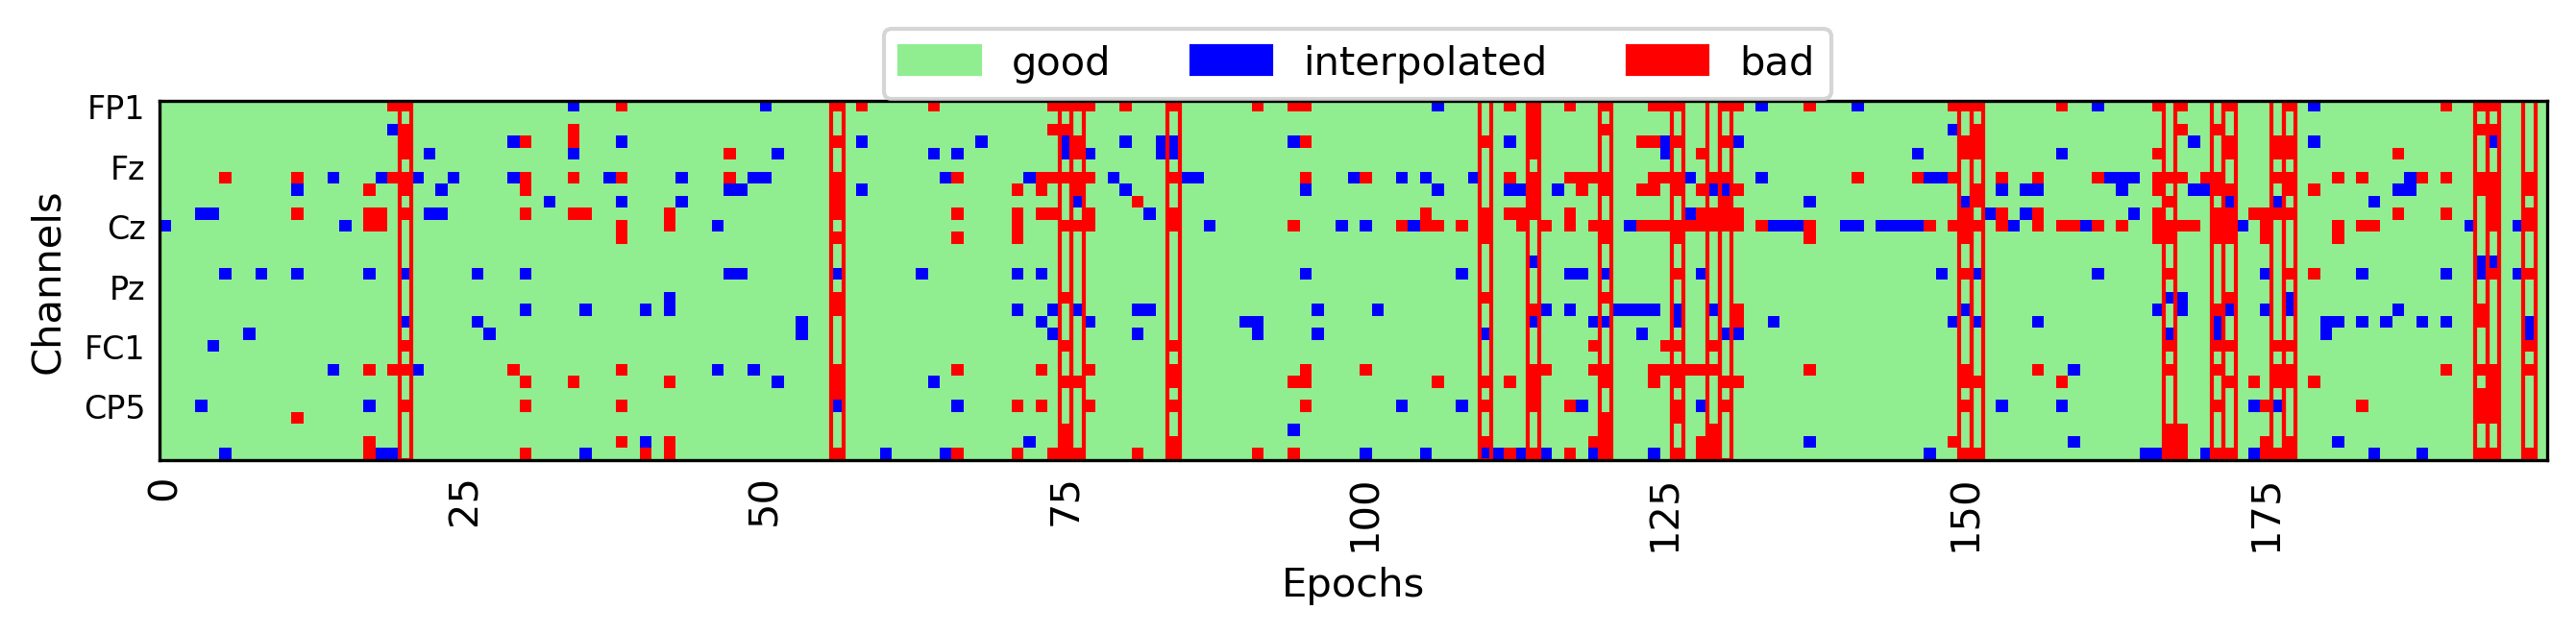

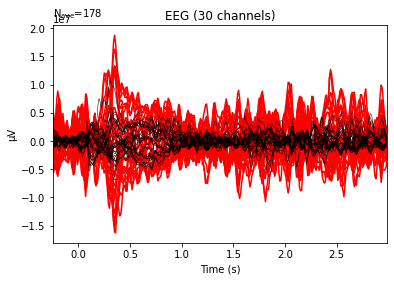

In [13]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(10,20), dpi=300)
reject_log.plot('horizontal', ax=ax)
plt.show()
evoked_bad = epochs[reject_log.bad_epochs].average()
plt.figure()
plt.plot(evoked_bad.times, evoked_bad.data.T * 1e6, 'r', zorder=-1)
epochs_ar.average().plot(axes=plt.gca());

Opening epochs-browser...


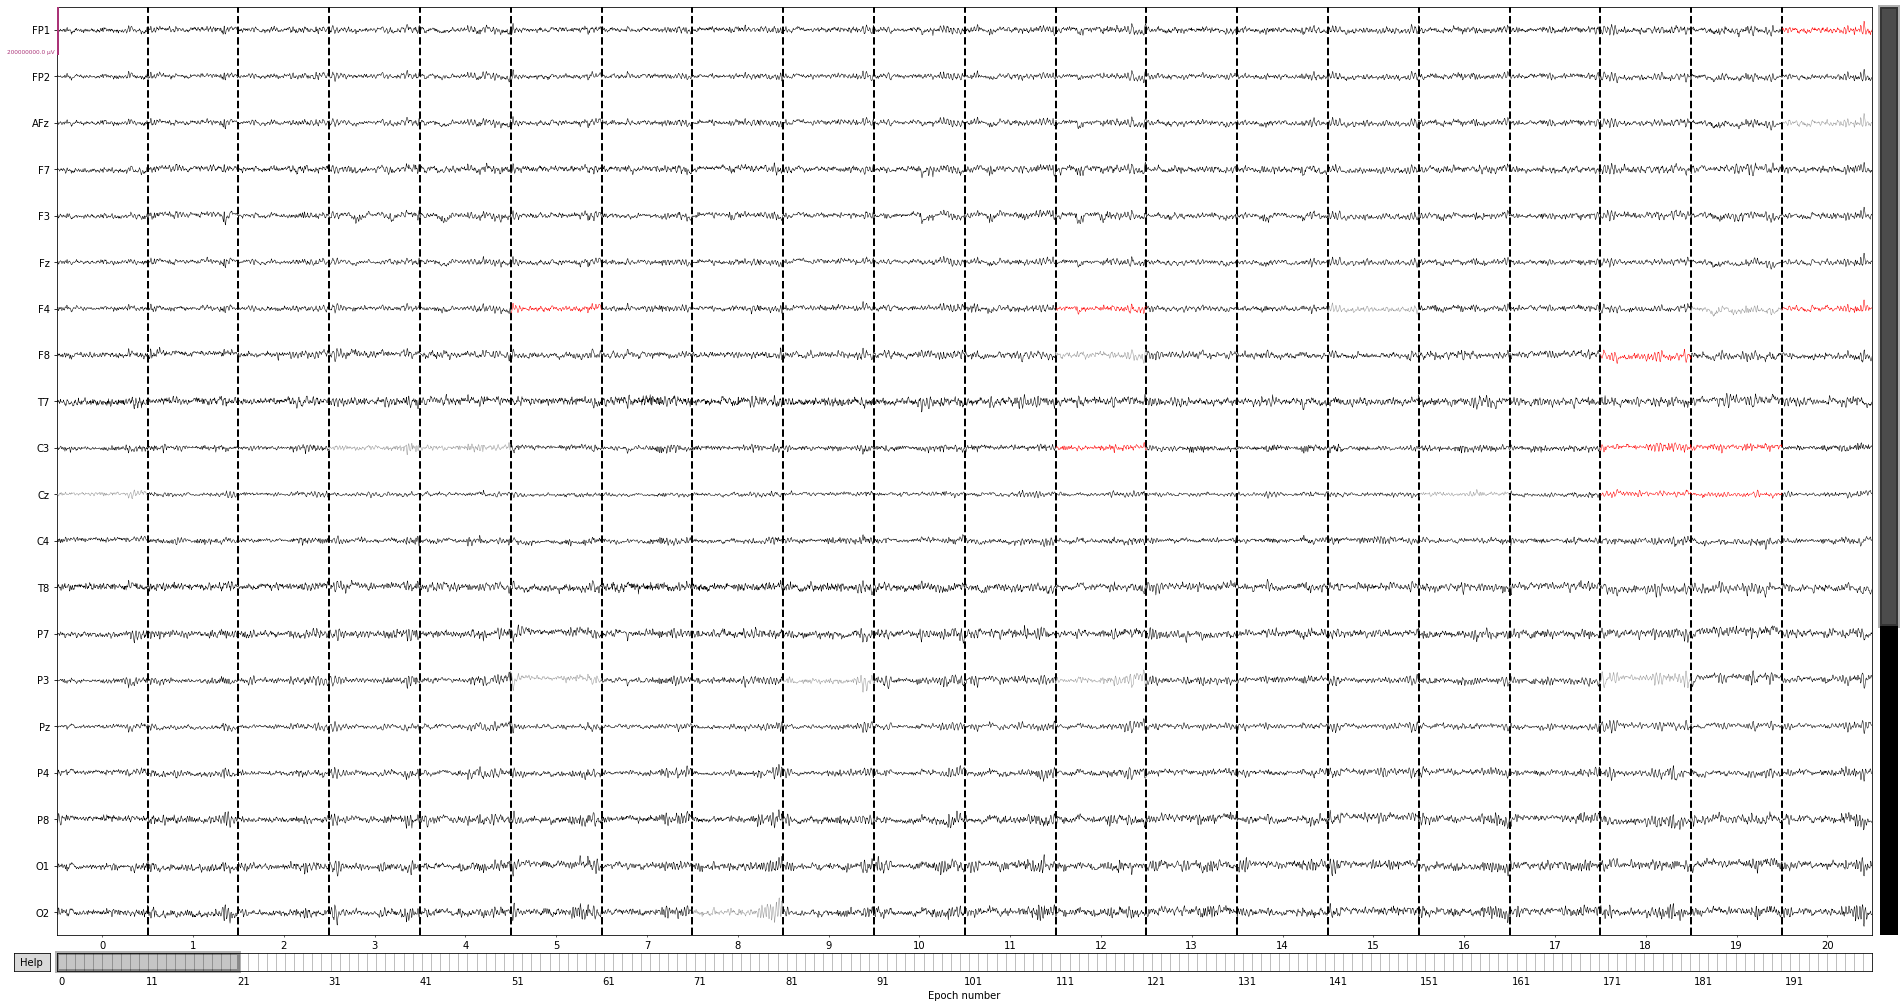

Closing epochs-browser...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [14]:
%matplotlib qt
reject_log.plot_epochs(epochs,scalings=dict(eeg=100))

  0%|          | Repairing epochs : 0/199 [00:00<?,       ?it/s]

Dropped 21 epochs: 20, 56, 75, 76, 84, 110, 114, 120, 126, 129, 130, 150, 151, 167, 171, 172, 176, 177, 193, 194, 197


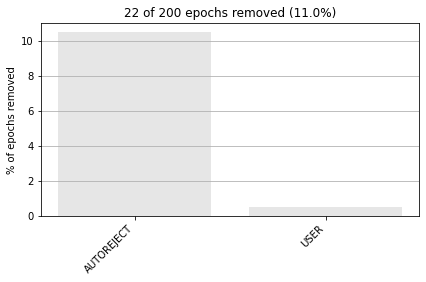

In [15]:
epochs_ar, reject_log = ar.transform(epochs, return_log=True)
%matplotlib inline
epochs_ar.plot_drop_log();

In [16]:
epochs_ar.to_data_frame().to_csv('%s.csv'%subj_num)#Saving csv
epochs_ar.save('%s_epo.fif'%subj_num, overwrite=True)#Saving EEG mne format